# Evaluation Analysis for Recommender Output

In this section we will analyze and compare the generated recommendations and predictions from a predefined list of algorithms with the goal of assessing the performance of each algorithm with respect to a metric. In other words, we would rank the algorithms for each metric considered with respect to performance.

## Setup

Below are the list of packages required to successfully run the analysis. They are divided into partitions to signify their specific task.<br>
We need the pathlib package for working with files and folders

In [1]:
from pathlib import Path
import json

We would use the pandas for analyzing and manipulating our data while seaborn and matplotlib are used for data visualization. statsmodels.graphics.gofplots and scipy.stats.shapiro are used for normality check. Scipy.stats.friedmanchisquare is a non-parametric test used to determine the statistical significance in metric results and the wilcoxon test is used for pairwise comparison of sample data.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from scipy.stats import friedmanchisquare, wilcoxon
from itertools import combinations

Import the LensKit metrics for analysis:

In [3]:
from lenskit.data import Dataset, ItemListCollection, UserIDKey
from lenskit.metrics import RunAnalysis, RMSE, NDCG, RecipRank, RBP

In [4]:
from lkdemo.datasets import split_fraction

## Load Data

The recommendations are in `runs`, and we will need to reassemble the test data from `test`.

In [5]:
dataset = "ml-100k"

In [6]:
# Parameters
dataset = "ml-latest-small"


In [7]:
output_root = Path("runs")

In [8]:
dirs = [fld for fld in output_root.glob(f'{dataset}-*')]

In [9]:
recs = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("recs-*"):
        rec = ItemListCollection.load_parquet(file)
        recs.add_from(rec, model=fld.name.split("-")[-1])

In [10]:
rec_algos = sorted(set(a for (a, _u) in recs.keys()))
rec_algos

['ALS', 'Bias', 'IALS', 'IIE', 'III', 'Pop', 'UUE']

In [11]:
preds = ItemListCollection(['model', 'user_id'], index=False)
for fld in dirs:
    for file in fld.glob("pred-*"):
        pred = ItemListCollection.load_parquet(file)
        preds.add_from(pred, model=fld.name.split("-")[-1])

We need to load the test data so that we have the ground truths for computing accuracy

In [12]:
data = Dataset.load(f"data/{dataset}")
split = split_fraction(data, 0.2)
test = split.test

## Top-N Metrics

`RunListAnalysis` computes metrics for recommendation results and takes care of
matching recommendations and ground truth.

In [13]:
ra = RunAnalysis()

ra.add_metric(NDCG())
ra.add_metric(RecipRank())
ra.add_metric(RBP())

rec_results = ra.compute(recs, test)
rec_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


mean        median       std
model                                            
ALS   NDCG       0.143585  1.232583e-01  0.109129
      RBP        0.301857  5.000000e-01  0.278593
      RecipRank  0.572264  1.000000e+00  0.451754
Bias  NDCG       0.144237  1.232583e-01  0.112597
      RBP        0.302009  5.000000e-01  0.281581
      RecipRank  0.569998  1.000000e+00  0.459706
IALS  NDCG       0.036128  1.190915e-02  0.087273
      RBP        0.017900  5.820766e-11  0.096810
      RecipRank  0.057071  2.941176e-02  0.123974
IIE   NDCG       0.003376  0.000000e+00  0.012898
      RBP        0.001393  0.000000e+00  0.011963
      RecipRank  0.008005  0.000000e+00  0.038480
III   NDCG       0.025775  0.000000e+00  0.080206
      RBP        0.026902  0.000000e+00  0.111105
      RecipRank  0.053646  0.000000e+00  0.181649
Pop   NDCG       0.217502  1.979622e-01  0.154321
      RBP        0.480820  5.001221e-01  0.386027
      RecipRank  0.637057  1.000000e+00  0.420176
UUE   NDCG       0.000188  0.000000e+00  0.001452
      RBP        0.000004  0.000000e+00  0.000045
      RecipRank  0.001129  0.000000e+00  0.009192

We can reshape the list metrics and plot them:

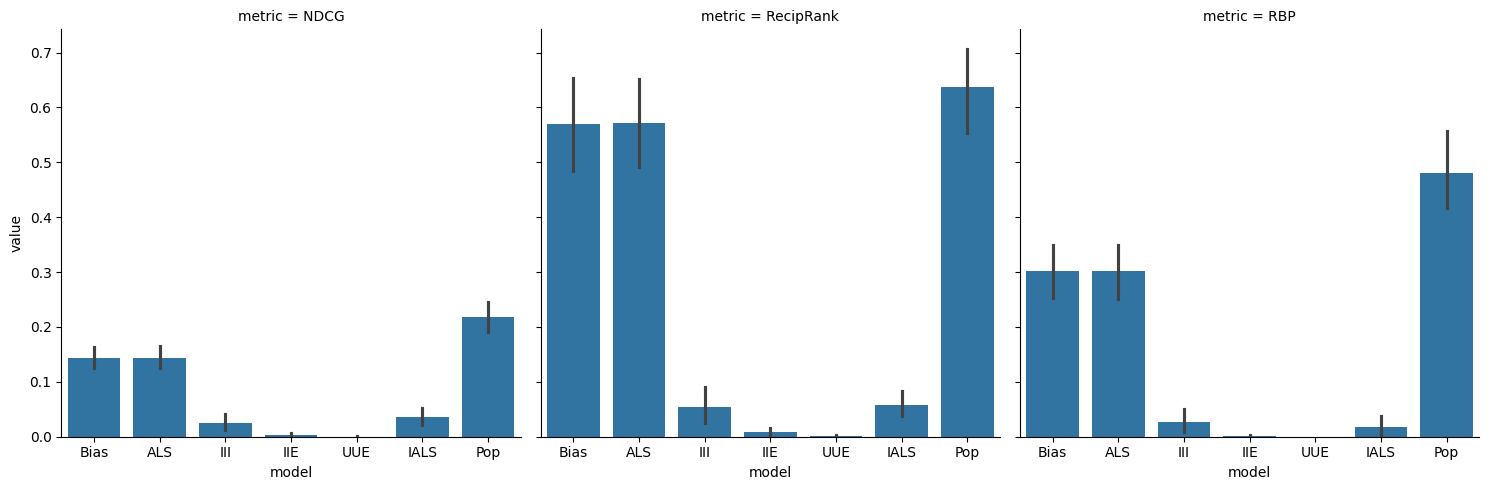

In [14]:
metrics = rec_results.list_metrics()
metrics = metrics.melt(var_name='metric', ignore_index=False).reset_index()
sns.catplot(metrics, x='model', y='value', col='metric', kind='bar')
plt.show()

## Prediction RMSE

We will also look at the prediction RMSE.

In [15]:
pa = RunAnalysis()

pa.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))

pred_results = pa.compute(preds, test)
pred_results.list_summary('model')

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,,mean,median,std
model,,,,
ALS,RMSE,0.961093,0.898315,0.343152
Bias,RMSE,0.965678,0.899920,0.346167
IIE,RMSE,0.996960,0.942495,0.358581
UUE,RMSE,1.005463,0.942495,0.356630


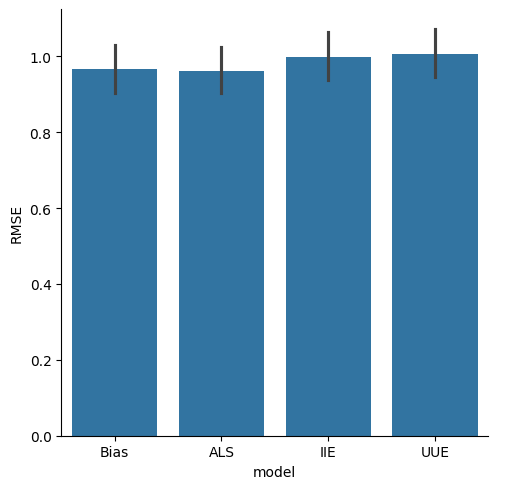

In [16]:
sns.catplot(pred_results.list_metrics().reset_index(), x='model', y='RMSE', kind='bar')
plt.show()

## Save Metrics

We'll now save the metrics to a file.

In [17]:
rlsum = rec_results.list_summary('model')['mean'].unstack()
rlsum

/home/mde48/lenskit/lk-demo-experiment/.venv/lib/python3.13/site-packages/lenskit/metrics/bulk.py:127: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = scores.groupby(list(keys)).agg(["mean", "median", "std"]).stack(level=0)


,NDCG,RBP,RecipRank
model,,,
ALS,0.143585,0.301857,0.572264
Bias,0.144237,0.302009,0.569998
IALS,0.036128,0.017900,0.057071
IIE,0.003376,0.001393,0.008005
III,0.025775,0.026902,0.053646
Pop,0.217502,0.480820,0.637057
UUE,0.000188,0.000004,0.001129


In [18]:
rlsum.to_json(f'eval-metrics.{dataset}.json', orient='index')